### Hotelling T2法（1次元バージョン）
参考文献:<br>
> 井出剛. 2015. 入門機械学習による異常検知. コロナ社. pp.15-36.

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from typing import Union, Literal

#### 1次元のデータにおける、ホテリングT2法の特徴
1. データは正規分布を仮定
2. 分布の当てはまり（≃平均からどの程度外れているか）をもとに異常度が定義されているため、直観的に理解しやすい
3. 異常度の閾値含め、種々の分布に基づきクリアに設定することが可能

#### ホテリングT2法の手順 <br>
#### 1. 分布の推定
データは正規分布に従うと仮定する。
$$
N(x|\mu, \sigma^2) = \frac{1}{(2 \pi \sigma^2)^{1/2}} \exp \biggl\{ - \frac{1}{2 \sigma^2} (x-\mu)^2 \biggr\}
$$

上式における $\mu$ は母集団における平均、$\sigma^2$は母集団における分散である。これらは一般に未知であるため推定する必要がある。<br>
上2変数は手元に存在するデータ集合 $D = \{ x^{(1)}, x^{(2)}, \cdots, x^{(N)} \}$ の最尤推定量は以下のように導出することができる。<br>


$$\hat{\mu} =\frac{1}{N} \sum_{n=1}^N x^{(n)}$$
$$\hat{\sigma^2} = \frac{1}{N} \sum_{n=1}^N (x^{(n)}-\hat{\mu})^2$$


#### 2. 異常度の定義
新たなデータx'が観測された場合、以下に定義される異常度として算出される。<br>
$$a(x') \equiv \biggr( \frac{x'-\hat{\mu}}{\hat{\sigma}} \biggl)^2$$

#### 3. 閾値の設定
異常度は $F$ 分布、もしくは $\chi^2$ 分布に従うことが示される。<br>
$$ \frac{N-1}{N+1} a(x') \sim F(1, N-1)$$
$$ a(x') \sim \chi^2(1, 1) \quad (N \gg 1)$$
仮説検定と同様に、閾値 $a_{th}$ を設定し、使用する分布の閾値を超える場合は異常とみなす。

### 関数の定義
上記に基づき、実装する

In [103]:
class HotellingT2:
    def __init__(self, a_threshold):
        #異常判定の閾値パーセンタイルのデフォルト値
        self.a_threshold = a_threshold
        self.x = None
        self.mu_hat = None
        self.sigma_hat = None
        self.sample_size = None

    def fit(self, x: np.ndarray):
        self.mu_hat = np.mean(x)
        self.sigma_hat = np.std(x)
        self.sample_size = len(x)
        self.x = x
    
    def get_anomaly_score(self, x_test: Union[float, np.ndarray]) -> Union[float, np.ndarray]:
        #異常度の算出
        anomaly_score = ((x_test - self.mu_hat)/ self.sigma_hat)**2
        return anomaly_score

    def anomaly_judgement(self, anomaly_score: Union[float, np.ndarray], dist: Literal["chi_square", "f"]) \
        -> Union[float, np.ndarray]:
        #χ二乗分布の場合
        if dist == "f":
            percentile = self.F_percentile(anomaly_score)
        else: #F分布の場合
            percentile = self.chi_square_percentile(anomaly_score)
        #異常判定    
        anomaly_judgement = (percentile < self.a_threshold)*1
        return anomaly_judgement

    def chi_square_percentile(self, anomaly_score: Union[float, np.ndarray]) -> Union[float, np.ndarray]:
        #自由度1, スケール因子1の χ二乗分布に従うため、異常値がどのパーセンタイルに対応するか算出する
        chi_square_percentile = stats.chi2.cdf(anomaly_score, df=1, scale=1)
        return 1 - chi_square_percentile

    def F_percentile(self, anomaly_score: Union[float, np.ndarray]) -> Union[float, np.ndarray]:
        #自由度（1, N-1）の F分布に従うため、異常値がどのパーセンタイルに対応するか算出する
        f_percentile = stats.f.cdf(anomaly_score, dfn=1, dfd=self.sample_size-1, scale=1)
        return 1 - f_percentile

### 例題への適用
Davisデータセットに適用する

In [46]:
df = pd.read_csv('https://vincentarelbundock.github.io/Rdatasets/csv/carData/Davis.csv', index_col=False)
df = df[['weight', 'height']]
df

,weight,height
0,77,182
1,58,161
2,53,161
3,68,177
4,59,157
...,...,...
195,74,175
196,83,180
197,81,175
198,90,181


簡単な可視化を行う

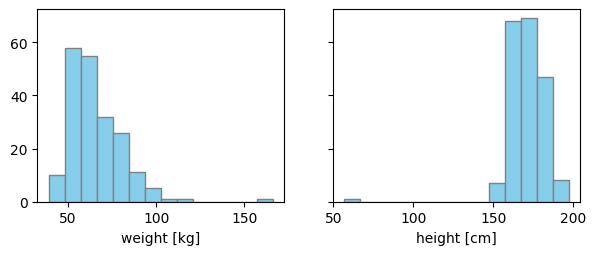

In [55]:
fig, ax = plt.subplots(1, 2, figsize=(7, 2.5), sharey="all")
ax[0].hist(df["weight"].values, bins=int(np.sqrt(len(df))), edgecolor="gray", facecolor="skyblue")
ax[0].set_xlabel("weight [kg]")
ax[1].hist(df["height"].values, bins=int(np.sqrt(len(df))), edgecolor="gray", facecolor="skyblue")
ax[1].set_xlabel("height [cm]")
plt.show()
plt.close()

下側半分のデータを基に、モデルを構築する。<br>
対象は体重データ。

In [104]:
#変数の定義
x = df["weight"].values
x_train, x_test = x[100:], x[:100]

#異常検知
cls = HotellingT2(a_threshold=0.01) #閾値：上位1%に設定
cls.fit(x_train)
anomaly_score_train, anomaly_score_test = cls.get_anomaly_score(x_train), cls.get_anomaly_score(x_test)
anomaly_train_flag, anomaly_test_flag = cls.anomaly_judgement(anomaly_score_train, dist="f"), \
                                        cls.anomaly_judgement(anomaly_score_test, dist="f")

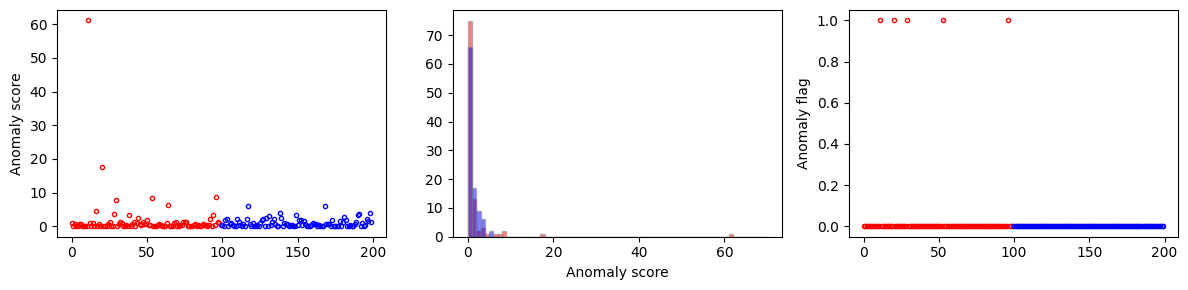

In [109]:
#結果の描画
fig, ax = plt.subplots(1, 3, figsize=(12, 3))
ax[0].plot(np.arange(len(anomaly_score_test)), anomaly_score_test, ls="", 
         marker="o", markerfacecolor="none", markeredgecolor="red", markersize=3)
ax[0].plot(np.arange(len(anomaly_score_test), len(anomaly_score_test)*2), anomaly_score_train, ls="", 
         marker="o", markerfacecolor="none", markeredgecolor="blue", markersize=3)
ax[0].set_ylabel("Anomaly score")

ax[1].hist(anomaly_score_test, facecolor="red", edgecolor="gray", range=(0, 70), bins=70, alpha=0.5)
ax[1].hist(anomaly_score_train, facecolor="blue", edgecolor="gray", range=(0, 70), bins=70, alpha=0.5)
ax[1].set_xlabel("Anomaly score")

ax[2].plot(np.arange(len(anomaly_score_test)), anomaly_test_flag, ls="", 
         marker="o", markerfacecolor="none", markeredgecolor="red", markersize=3)
ax[2].plot(np.arange(len(anomaly_score_test), len(anomaly_score_test)*2), anomaly_train_flag, ls="", 
         marker="o", markerfacecolor="none", markeredgecolor="blue", markersize=3)
ax[2].set_ylabel("Anomaly flag")

plt.tight_layout()
plt.show()
plt.close()